<a href="https://colab.research.google.com/github/brepowell/ML-Contest-Series/blob/main/MLSeriesSupervisedLearningTemplate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To run:
Use an IDE that will allow you to open a Jupyter Notebook.

For example, use Anaconda Navigator to open Visual Studio Code.

You may need to select a kernel to run the program.

# STEP 1: DATA GATHERING / FEATURE EXPLORATION

## Import Libraries

In [273]:
# This step can be done in any cell of the notebook. It does not have to be at the top.
import pandas as pd


## Data Information

From
https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

"Created 9 years ago, updated 2 years ago
Energy consumption readings for a sample of 5,567 London Households that took part in the UK Power Networks led Low Carbon London project between November 2011 and February 2014.

Readings were taken at half hourly intervals. The customers in the trial were recruited as a balanced sample representative of the Greater London population.

The dataset contains energy consumption, in kWh (per half hour), unique household identifier, date and time. The CSV file is around 10GB when unzipped and contains around 167million rows.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period. The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.

The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress.

The remaining sample of approximately 4500 customers energy consumption readings were not subject to the dToU tariff."


## Load Data -- Daily

In [274]:
# Use Pandas to load the data into a dataframe
path = "data/archive/"
startYear = 2011   # 2011-12-15	is the earliest day I can find in the dataset
endYear = 2014     #"2014-02-28" is the last day I can find in the dataset

londonData = pd.read_csv(path + 'daily_dataset.csv')
londonData.shape


(3510433, 9)

## Load Data -- Half Hourly

In [275]:
# tstp = Time Series Time Period (day)
# This shows readings every half hour (LCLid + tstp + energy(kWh/hh) = 3 columns)
path = "data/archive/halfhourly_dataset/halfhourly_dataset/"
block1 = pd.read_csv(path + 'block_0.csv')
block1.shape


(1222670, 3)

## Load Data -- Half Hourly 2nd set

In [276]:
# This shows readings every half hour (LCLid + day + 48 half hour columns = 50 columns) per day, per ID
# It is the same data as the halfhourly_dataset, except formatted differently and with more precision.
path = "data/archive/hhblock_dataset/hhblock_dataset/"
halfblock0 = pd.read_csv(path + 'block_0.csv')
halfblock0.shape

(25286, 50)

## Check the Min/Max/Avg -- Daily

In [277]:
londonData.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [278]:
londonData.tail() 

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046
3510431,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047
3510432,MAC004977,2014-02-28,0.0970,0.097000,0.097,1,NaN,0.097,0.097


In [279]:
londonData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510433 entries, 0 to 3510432
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LCLid          object 
 1   day            object 
 2   energy_median  float64
 3   energy_mean    float64
 4   energy_max     float64
 5   energy_count   int64  
 6   energy_std     float64
 7   energy_sum     float64
 8   energy_min     float64
dtypes: float64(6), int64(1), object(2)
memory usage: 241.0+ MB


In [280]:
# Zero is the minimum for all
londonData.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,3.510403e+06,3.510403e+06,3.510403e+06,3.510433e+06,3.499102e+06,3.510403e+06,3.510403e+06
mean,1.587395e-01,2.117305e-01,8.345210e-01,4.780364e+01,1.726673e-01,1.012414e+01,5.962578e-02
std,1.701865e-01,1.908460e-01,6.683156e-01,2.810982e+00,1.531208e-01,9.128793e+00,8.701312e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.700000e-02,9.808333e-02,3.460000e-01,4.800000e+01,6.911626e-02,4.682000e+00,2.000000e-02
50%,1.145000e-01,1.632917e-01,6.880000e-01,4.800000e+01,1.327910e-01,7.815000e+00,3.900000e-02
75%,1.910000e-01,2.624583e-01,1.128000e+00,4.800000e+01,2.293124e-01,1.256900e+01,7.100000e-02
max,6.970500e+00,6.928250e+00,1.076100e+01,4.800000e+01,4.024569e+00,3.325560e+02,6.524000e+00


In [281]:
# There are 5566 distinct LCLids (customers)
customerIDs = londonData.groupby("LCLid").count()
customerIDs.shape


(5566, 8)

In [282]:
customerIDs.head()

,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
LCLid,,,,,,,,
MAC000002,505,505,505,505,505,503,505,505
MAC000003,740,740,740,740,740,739,740,740
MAC000004,662,662,662,662,662,660,662,662
MAC000005,638,638,638,638,638,636,638,638
MAC000006,761,761,761,761,761,760,761,761


In [283]:
# Looking at min, it appears that there are LCLids that only have line of information!
customerIDs.describe()["day"]

count    5566.000000
mean      630.692239
std       111.945099
min         1.000000
25%       600.000000
50%       651.000000
75%       684.000000
max       829.000000
Name: day, dtype: float64

## Power Outage Days

In [284]:
# There are possibly 15,138 power outages, where max energy was 0 for the day
zeroPower = londonData[londonData['energy_max'] == 0]
zeroPower.shape

(15138, 9)

In [285]:
# I wonder what energy_count is????
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
12271,MAC004560,2013-04-02,0.0,0.0,0.0,48,0.0,0.0,0.0
12272,MAC004560,2013-04-03,0.0,0.0,0.0,48,0.0,0.0,0.0
12273,MAC004560,2013-04-04,0.0,0.0,0.0,48,0.0,0.0,0.0
12274,MAC004560,2013-04-05,0.0,0.0,0.0,1,NaN,0.0,0.0
41810,MAC001340,2013-11-15,0.0,0.0,0.0,48,0.0,0.0,0.0


In [286]:
zeroPower.to_csv("PowerOutages.csv")

In [287]:
# Convert to datetime
zeroPower['day'] = pd.to_datetime(zeroPower['day'])

C:\Users\brely\AppData\Local\Temp\ipykernel_48160\2167483632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower['day'] = pd.to_datetime(zeroPower['day'])


In [288]:
# There are possibly 819 days where the power was out for at least one location
zeroPowerDays = zeroPower.groupby("day").count()
zeroPowerDays.drop(zeroPowerDays.columns.difference(['LCLid']), axis=1, inplace=True)
zeroPowerDays.shape

(819, 1)

In [289]:
zeroPowerDays.head()

,LCLid
day,
2011-11-29,1
2011-11-30,1
2011-12-01,1
2011-12-02,1
2011-12-04,1


In [290]:
# There was a day where 62 customers were without power
zeroPowerDays.describe()

,LCLid
count,819.000000
mean,18.483516
std,9.329117
min,1.000000
25%,13.000000
50%,21.000000
75%,25.000000
max,62.000000


In [291]:
blackoutDay = zeroPowerDays[zeroPowerDays.eq(62).any(axis=1)]
blackoutDay


,LCLid
day,
2014-02-28,62


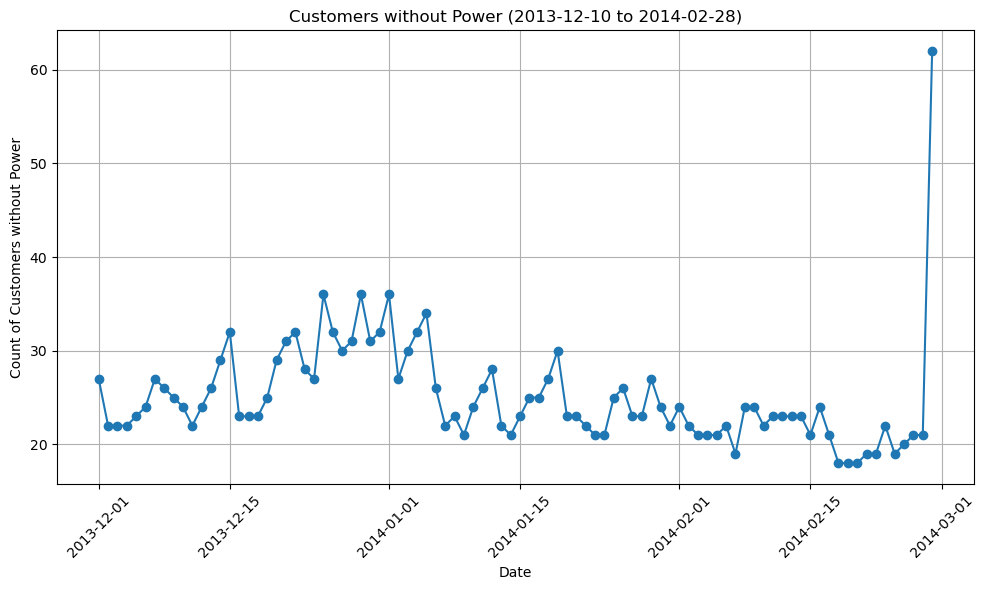

In [292]:
import matplotlib.pyplot as plt 

# Filter the DataFrame to include only the rows within the specified date range
subset_data = zeroPowerDays['2013-12-01':'2014-02-28']

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(subset_data.index, subset_data['LCLid'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Count of Customers without Power')
plt.title('Customers without Power (2013-12-10 to 2014-02-28)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [293]:
# There are possibly 281 customers affected by a power outage
zeroPowerIDs = zeroPower.groupby("LCLid").count()
zeroPowerIDs.shape

(281, 8)

In [294]:
zeroPower.sort_values(by=['day'], inplace=True)

C:\Users\brely\AppData\Local\Temp\ipykernel_48160\3317076614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zeroPower.sort_values(by=['day'], inplace=True)


In [295]:
zeroPower.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
2127696,MAC000197,2011-11-29,0.0,0.0,0.0,48,0.0,0.0,0.0
2127697,MAC000197,2011-11-30,0.0,0.0,0.0,48,0.0,0.0,0.0
2127698,MAC000197,2011-12-01,0.0,0.0,0.0,48,0.0,0.0,0.0
2127699,MAC000197,2011-12-02,0.0,0.0,0.0,48,0.0,0.0,0.0
2127701,MAC000197,2011-12-04,0.0,0.0,0.0,48,0.0,0.0,0.0


In [296]:
zeroPower.tail()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
2467769,MAC002439,2014-02-28,0.0,0.0,0.0,1,NaN,0.0,0.0
2415597,MAC001091,2014-02-28,0.0,0.0,0.0,1,NaN,0.0,0.0
2307338,MAC004070,2014-02-28,0.0,0.0,0.0,1,NaN,0.0,0.0
1327877,MAC002564,2014-02-28,0.0,0.0,0.0,1,NaN,0.0,0.0
1215649,MAC002594,2014-02-28,0.0,0.0,0.0,1,NaN,0.0,0.0


## Customer Information

In [297]:
# Use Pandas to load the data into a dataframe
path = "data/archive/"
house = pd.read_csv(path + 'informations_households.csv')

In [298]:
# Looking at that house that was dead for a long time
house[house["LCLid"] == "MAC001340"]

,LCLid,stdorToU,Acorn,Acorn_grouped,file
4394,MAC001340,Std,ACORN-N,Adversity,block_87


In [299]:
# Use Pandas to load the data into a dataframe
#path = "data/archive/"
#acorn = pd.read_csv(path + 'acorn_details.csv', encoding="utf-16")

## Check the Min/Max/Avg -- 1/2 Hourly

In [300]:
block1.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00.0000000,0
1,MAC000002,2012-10-12 01:00:00.0000000,0
2,MAC000002,2012-10-12 01:30:00.0000000,0
3,MAC000002,2012-10-12 02:00:00.0000000,0
4,MAC000002,2012-10-12 02:30:00.0000000,0


In [301]:
block1.tail()

,LCLid,tstp,energy(kWh/hh)
1222665,MAC005492,2014-02-27 22:00:00.0000000,0.182
1222666,MAC005492,2014-02-27 22:30:00.0000000,0.122
1222667,MAC005492,2014-02-27 23:00:00.0000000,0.14
1222668,MAC005492,2014-02-27 23:30:00.0000000,0.192
1222669,MAC005492,2014-02-28 00:00:00.0000000,0.088


In [302]:
block1.describe()

,LCLid,tstp,energy(kWh/hh)
count,1222670,1222670,1222670
unique,50,39292,5022
top,MAC000246,2012-12-16 00:00:00.0000000,0.013
freq,39245,50,6238


In [303]:
# The halfhourly block files only show around 50 locations, due to the granularity of half hour
hourlycustomerIDs = block1.groupby("LCLid").count()
hourlycustomerIDs.shape

(50, 2)

## Check for Imbalanced Data

# STEP 2: FEATURE ENGINEERING / DATA CLEANING / PRE-PROCESSING TECHNIQUES

## Label your target variable

In [304]:
# Ex) Change "yes" or "no" to 1 or 0 so the model understands the label

## Fix the data imbalance and other problems from STEP 1

## Seperate features (x) from labels (y)

## Feature Reduction

## Normalize / Scale the Data

## Investigate Variance or Feature Importance

# STEP 3: MODEL TRAINING & BUILDING


## Split into Train and Test data

## Use a Model

## Perform a Hyperparameter Search

## Save the best model

# STEP 4: EVALUATE THE MODEL

## Look at Metrics - Ex) Precision, Recall, F1 score

## Plot a Confusion Matrix

# STEP 5: DEPLOY MODEL